## PRISM data not concatenating correctly for all sites

## Processing Sensor Data from Catalina Jemez CZO Green Pit 1
Marc Berghouse 9/19/2020

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE

Issues:
- Not sure how to deal with the A and B sensor values. Right now, if the dates for A and B don't overlap, I am combining the data in a new colum, then deleting the A and B columns. If the dates do overlap, I just leave both A and B columns in the dataframe
- I'm not sure which water potential values are unrealistic

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
infile1 = "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_co2o2_2015.csv"
infile2 = "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_co2o2_2016.csv"
infile3 = "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_co2o2_2017.csv"
infile4 = "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_co2o2_2018.csv"
infile5 = "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_soilMTP_2015.csv"
infile6 = "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_soilMTP_2016.csv"
infile7 = "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_soilMTP_2017.csv"
infile8 = "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_soilMTP_2018.csv"
infile9 = "../../raw_data/Catalina-Jemez/Catalina-Jemez_Green_PRISM.csv"


df1 = pd.read_csv(infile1, na_values='NAN',  parse_dates=[0], index_col=0) 
df2 = pd.read_csv(infile2, na_values='NAN',  parse_dates=[0], index_col=0) 
df3 = pd.read_csv(infile3, na_values='NAN',  parse_dates=[0], index_col=0) 
df4 = pd.read_csv(infile4, na_values='NAN',  parse_dates=[0], index_col=0) 
df5 = pd.read_csv(infile5, na_values='NAN',  parse_dates=[0], index_col=0) 
df6 = pd.read_csv(infile6, na_values='NAN',  parse_dates=[0], index_col=0) 
df7 = pd.read_csv(infile7, na_values='NAN',  parse_dates=[0], index_col=0) 
df8 = pd.read_csv(infile8, na_values='NAN',  parse_dates=[0], index_col=0) 
df9 = pd.read_csv(infile9, na_values=['NAN',-9999,-99999], skiprows=10, parse_dates=[0], index_col=0) 


C:\Users\marcb\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
#drop metadata rows

df1=df1.drop(['MST'])
df2=df2.drop(['MST'])
df3=df3.drop(['MST'])
df4=df4.drop(['MST'])
df5=df5.drop(['MST'])
df6=df6.drop(['MST'])
df7=df7.drop(['MST'])
df8=df8.drop(['MST'])

df4

,TempSO1(2cm),TempSO2(10cm),TempSO3(30cm),TempSO4(60cm),O2soil1(2cm),O2soil2(10cm),O2soil3(30cm),O2soil4(60cm),CO2soil1(2cm),CO2soil2(10cm),CO2soil3(30cm),CO2soil4(60cm)
TIMESTAMP,,,,,,,,,,,,
1/1/2018 0:00,0.38,2.72,4.035,6.982,19.731,20.152,20.82,20.849,732.126,1300.717,1984.102,2578.293
1/1/2018 0:15,0.329,2.714,4.035,6.982,19.734,20.164,20.82,20.849,735.861,1300.717,1975.902,2563.899
1/1/2018 0:30,0.283,2.7,4.035,6.98,19.737,20.166,20.82,20.849,737.319,1303.45,1991.572,2552.419
1/1/2018 0:45,0.243,2.698,4.035,6.978,19.74,20.166,20.82,20.849,737.137,1301.537,1960.779,2547.317
1/1/2018 1:00,0.216,2.696,4.035,6.977,19.721,20.167,20.82,20.849,736.499,1304.088,1984.648,2577.2
...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/2018 22:45,-0.001,0.849,2.555,5.903,22.027,19.422,17.851,21.819,2496.351,2913.572,3371.305,2581.702
12/31/2018 23:00,0,0.847,2.555,5.903,22.027,19.422,17.851,21.82,2499.265,2904.115,3389.722,2589.908
12/31/2018 23:15,0,0.847,2.555,5.903,22.027,19.422,17.851,21.82,2483.946,2911.044,3384.479,2601.952


In [3]:
#df9=df9.loc[0:4]
df6

,WP1(10cm),WP2(30cm),TempMPS1(10cm),TempMPS2(30cm),VWC1(10cm),VWC2(30cm),VWC3(60cm),VWC4(135cm),EC1(10cm),EC2(30cm),EC3(60cm),EC4(135cm),Temp5TE1(10cm),Temp5TE2(30cm),Temp5TE3(60cm),Temp5TE4(135cm)
TIMESTAMP,,,,,,,,,,,,,,,,
1/1/2016 0:00,-19.7,-22.2,0.3,1.9,0.118,0.148,0.167,0.082,0.02,0.03,0.01,0,0.1,1.5,3.2,6.5
1/1/2016 0:15,-19.6,-22.1,0.3,1.9,0.118,0.147,0.167,0.082,0.02,0.03,0.01,0,0,1.5,3.2,6.5
1/1/2016 0:30,-19.6,-22,0.3,1.9,0.118,0.147,0.167,0.083,0.01,0.03,0.01,0,0.1,1.5,3.2,6.5
1/1/2016 0:45,-20.7,-22.1,0.3,1.9,0.118,0.147,0.167,0.082,0.02,0.03,0.01,0,0,1.5,3.2,6.4
1/1/2016 1:00,-20.8,-22.1,0.3,1.9,0.118,0.147,0.167,0.082,0.01,0.04,0.01,0,0,1.5,3.2,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/2016 22:45,-81,-9999,0.7,2.2,-9999,0.065,-9999,-9999,-9999,0.02,-9999,-9999,-9999,1.7,-9999,-9999
12/31/2016 23:00,-81.4,-9999,0.7,2.2,-9999,0.065,-9999,-9999,-9999,0.02,-9999,-9999,-9999,1.7,-9999,-9999
12/31/2016 23:15,-80,-9999,0.7,2.2,-9999,0.065,-9999,-9999,-9999,0.02,-9999,-9999,-9999,1.7,-9999,-9999


In [4]:
#Merge dataframes, rename columns, mask whole dataframe, create new columns

df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9], sort=False)

df.columns=['ApogeeTemp_2cm.deg.C', 'ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100','O2_10cm.percent.0-100', 'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100', 'CO2_2cm.ppm', 'CO2_10cm.ppm', 'CO2_30cm.ppm', 'CO2_60cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa', 'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoistureA_10cm.m3m3', 'SoilMoistureA_30cm.m3m3', 'SoilMoistureA_60cm.m3m3', 'SoilMoistureA_135cm.m3m3', 'BulkECA_10cm.dS/m', 'BulkECA_30cm.dS/m', 'BulkECA_60cm.dS/m', 'BulkECA_135cm.dS/m', 'Decagon5TETempA_10cm.deg.C','Decagon5TETempA_30cm.deg.C', 'Decagon5TETempA_60cm.deg.C', 'Decagon5TETempA_135cm.deg.C', 'SoilMoistureB_10cm.m3m3', 'SoilMoistureB_30cm.m3m3', 'SoilMoistureB_60cm.m3m3', 'SoilMoistureB_135cm.m3m3', 'BulkECB_10cm.dS/m', 'BulkECB_30cm.dS/m', 'BulkECB_60cm.dS/m', 'BulkECB_135cm.dS/m', 'Decagon5TETempB_10cm.deg.C', 'Decagon5TETempB_30cm.deg.C', 'Decagon5TETempB_60cm.deg.C', 'Decagon5TETempB_135cm.deg.C', 'PRISM_precip.mm'  ]

df=df.astype(float)
df['WaterPotential_10cm.kPa']=abs(df['WaterPotential_10cm.kPa'])
df['WaterPotential_30cm.kPa']=abs(df['WaterPotential_30cm.kPa'])
df.mask(df<=-0.01, inplace=True)
df=df.fillna(value=0)

df['SoilMoisture_10cm.m3m3']=df['SoilMoistureA_10cm.m3m3']+df['SoilMoistureB_10cm.m3m3']
df['SoilMoisture_60cm.m3m3']=df['SoilMoistureA_60cm.m3m3']+df['SoilMoistureB_60cm.m3m3']
df['SoilMoisture_135cm.m3m3']=df['SoilMoistureA_135cm.m3m3']+df['SoilMoistureB_135cm.m3m3']
df['Decagon5TETemp_10cm.deg.C']=df['Decagon5TETempA_10cm.deg.C']+df['Decagon5TETempB_10cm.deg.C']
df['Decagon5TETemp_30cm.deg.C']=df['Decagon5TETempA_30cm.deg.C']+df['Decagon5TETempB_30cm.deg.C']
df['Decagon5TETemp_60cm.deg.C']=df['Decagon5TETempA_60cm.deg.C']+df['Decagon5TETempB_60cm.deg.C']
df['Decagon5TETemp_135cm.deg.C']=df['Decagon5TETempA_135cm.deg.C']+df['Decagon5TETempB_135cm.deg.C']
df['BulkEC_10cm.dS/m']=df['BulkECA_10cm.dS/m']+df['BulkECB_10cm.dS/m']
df['BulkEC_30cm.dS/m']=df['BulkECA_30cm.dS/m']+df['BulkECB_30cm.dS/m']
df['BulkEC_60cm.dS/m']=df['BulkECA_60cm.dS/m']+df['BulkECB_60cm.dS/m']
df['BulkEC_135cm.dS/m']=df['BulkECA_135cm.dS/m']+df['BulkECB_135cm.dS/m']

df

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,...,SoilMoisture_60cm.m3m3,SoilMoisture_135cm.m3m3,Decagon5TETemp_10cm.deg.C,Decagon5TETemp_30cm.deg.C,Decagon5TETemp_60cm.deg.C,Decagon5TETemp_135cm.deg.C,BulkEC_10cm.dS/m,BulkEC_30cm.dS/m,BulkEC_60cm.dS/m,BulkEC_135cm.dS/m
10/23/2015 9:30,3.594,7.473,8.689,11.175,19.754,19.506,20.781,20.494,760.036,872.332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10/23/2015 9:45,3.750,7.621,8.875,11.416,20.063,19.929,21.231,20.948,765.288,896.402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10/23/2015 10:00,3.878,7.605,8.870,11.412,19.967,19.935,21.229,20.948,771.416,906.071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10/23/2015 10:15,4.100,7.631,8.887,11.445,19.964,19.955,21.213,20.954,773.689,917.356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10/23/2015 10:30,4.511,7.689,8.938,11.502,19.984,19.959,21.205,20.980,776.056,935.109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-28 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-29 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-30 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#More corrections to whole DataFrame

df.mask(df==0.000, inplace=True)
df

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,...,SoilMoisture_60cm.m3m3,SoilMoisture_135cm.m3m3,Decagon5TETemp_10cm.deg.C,Decagon5TETemp_30cm.deg.C,Decagon5TETemp_60cm.deg.C,Decagon5TETemp_135cm.deg.C,BulkEC_10cm.dS/m,BulkEC_30cm.dS/m,BulkEC_60cm.dS/m,BulkEC_135cm.dS/m
10/23/2015 9:30,3.594,7.473,8.689,11.175,19.754,19.506,20.781,20.494,760.036,872.332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 9:45,3.750,7.621,8.875,11.416,20.063,19.929,21.231,20.948,765.288,896.402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 10:00,3.878,7.605,8.870,11.412,19.967,19.935,21.229,20.948,771.416,906.071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 10:15,4.100,7.631,8.887,11.445,19.964,19.955,21.213,20.954,773.689,917.356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 10:30,4.511,7.689,8.938,11.502,19.984,19.959,21.205,20.980,776.056,935.109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


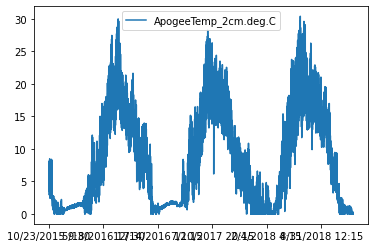

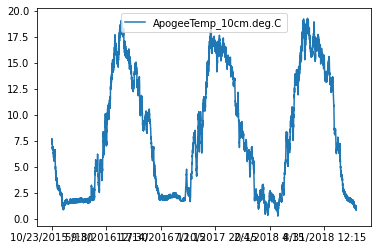

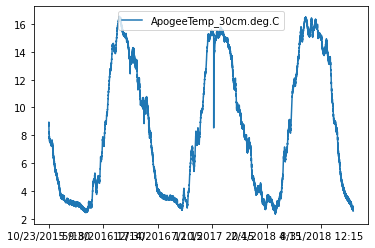

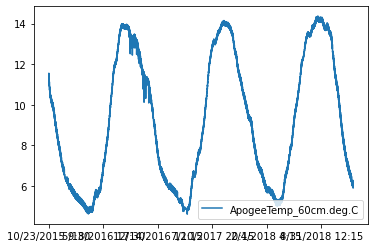

In [6]:
#Plot Apogee Temp

plt.show()
df.plot(use_index=True, y='ApogeeTemp_2cm.deg.C')
df.plot(use_index=True, y='ApogeeTemp_10cm.deg.C')
df.plot(use_index=True, y='ApogeeTemp_30cm.deg.C')
df.plot(use_index=True, y='ApogeeTemp_60cm.deg.C')


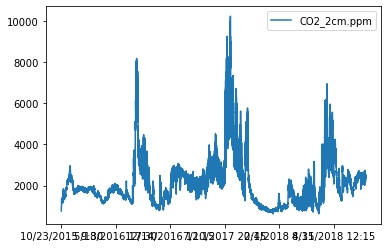

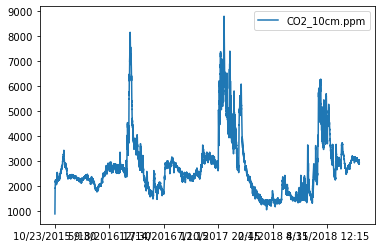

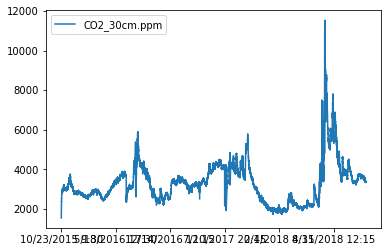

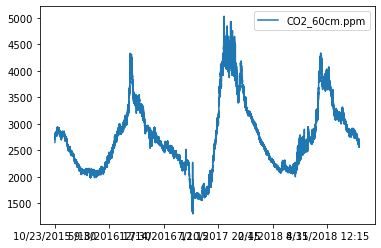

In [7]:
#Plot CO2 

plt.show()
df.plot(use_index=True, y='CO2_2cm.ppm')
df.plot(use_index=True, y='CO2_10cm.ppm')
df.plot(use_index=True, y='CO2_30cm.ppm')
df.plot(use_index=True, y='CO2_60cm.ppm')



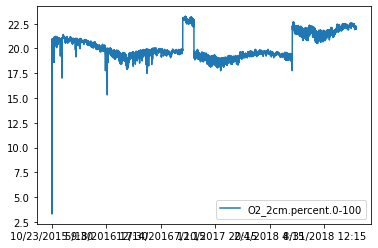

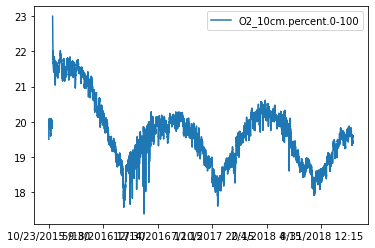

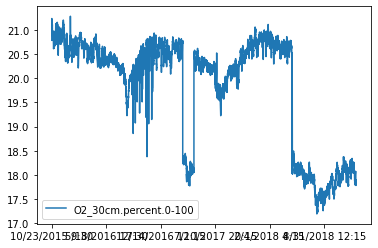

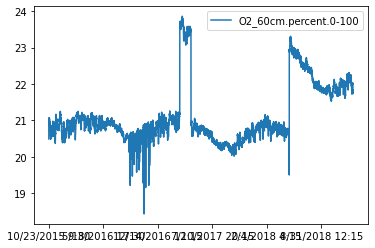

In [8]:
#Plot O2
df['O2_10cm.percent.0-100'].mask(df['O2_10cm.percent.0-100']>=23, inplace=True)

plt.show()
df.plot(use_index=True, y='O2_2cm.percent.0-100')
df.plot(use_index=True, y='O2_10cm.percent.0-100')
df.plot(use_index=True, y='O2_30cm.percent.0-100')
df.plot(use_index=True, y='O2_60cm.percent.0-100')


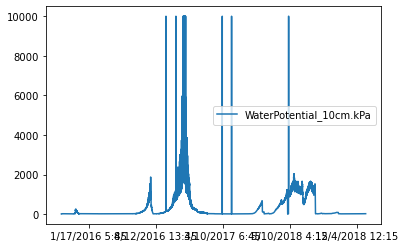

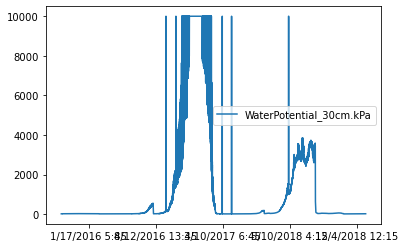

In [9]:
#Water potential has negative values, which I have masked out of the df. 
#I am thinking of taking the absolute value before masking the df.

plt.show()
df.plot(use_index=True, y='WaterPotential_10cm.kPa')
df.plot(use_index=True, y='WaterPotential_30cm.kPa')

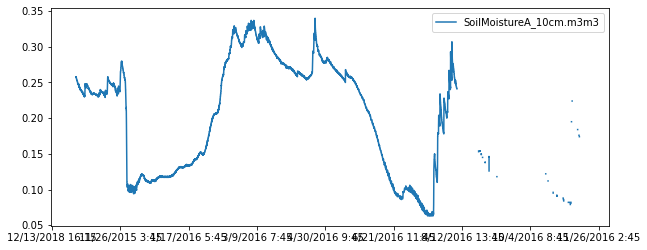

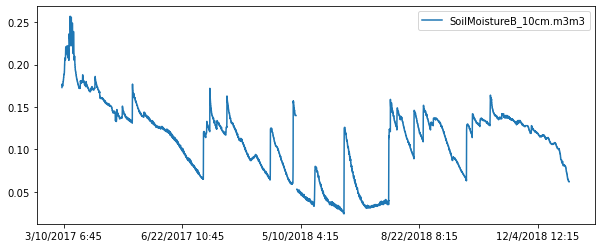

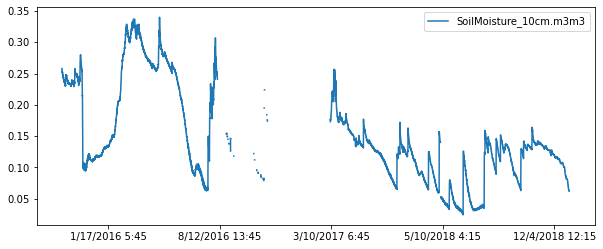

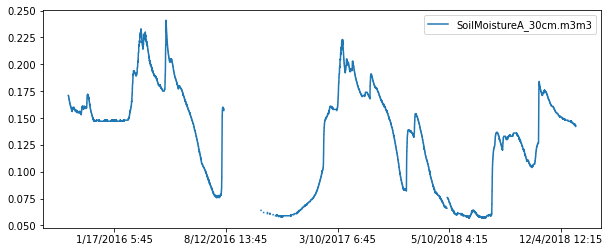

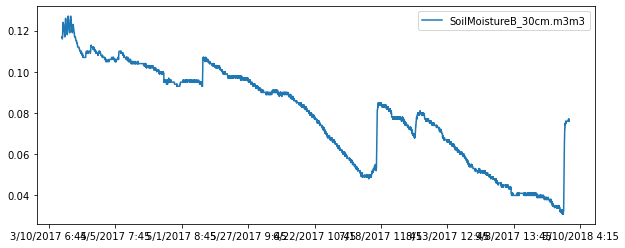

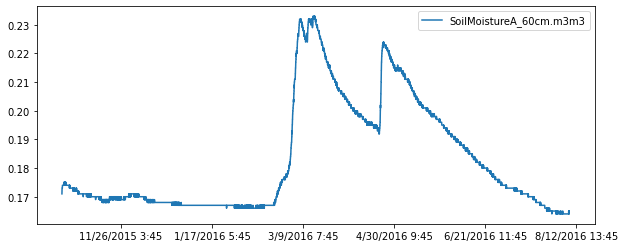

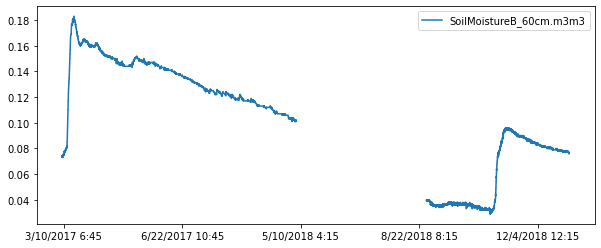

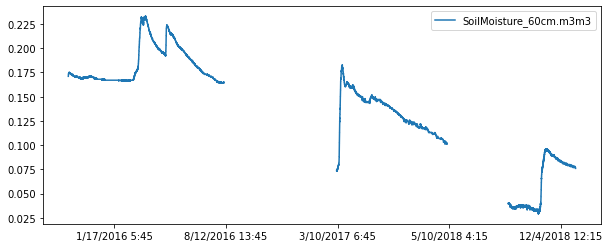

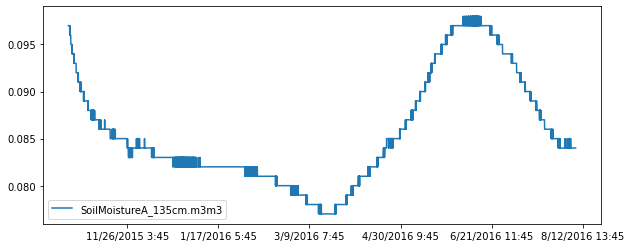

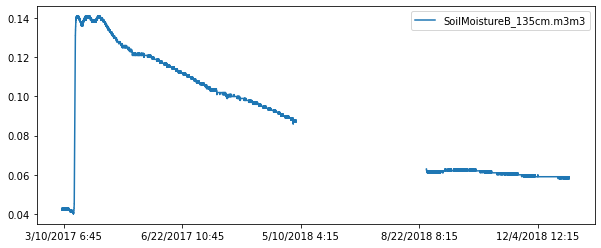

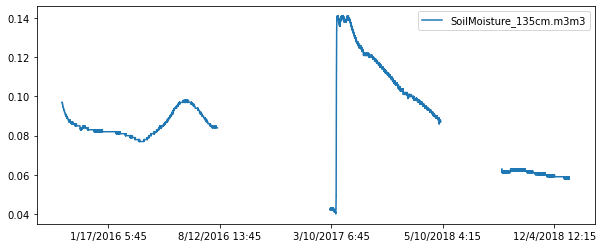

In [10]:
#Plot Soil Moisture
#I'm not sure what A and B correspond to. It seems around 2017 the A sensors were replaced with B sensors, so I have created new columns where the A and B sensor data is combined.
#Soil moisture at 30cm cannot be combined, because the dates for sensors A and B overlap

plt.show()
df.plot(use_index=True, y='SoilMoistureA_10cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoistureB_10cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoisture_10cm.m3m3', figsize=(10,4))


df.plot(use_index=True, y='SoilMoistureA_30cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoistureB_30cm.m3m3', figsize=(10,4))


df.plot(use_index=True, y='SoilMoistureA_60cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoistureB_60cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoisture_60cm.m3m3', figsize=(10,4))


df.plot(use_index=True, y='SoilMoistureA_135cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoistureB_135cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoisture_135cm.m3m3', figsize=(10,4))




In [11]:
df=df.drop(columns='SoilMoistureA_10cm.m3m3')
df=df.drop(columns='SoilMoistureB_10cm.m3m3')
df=df.drop(columns='SoilMoistureA_60cm.m3m3')
df=df.drop(columns='SoilMoistureB_60cm.m3m3')
df=df.drop(columns='SoilMoistureA_135cm.m3m3')
df=df.drop(columns='SoilMoistureB_135cm.m3m3')




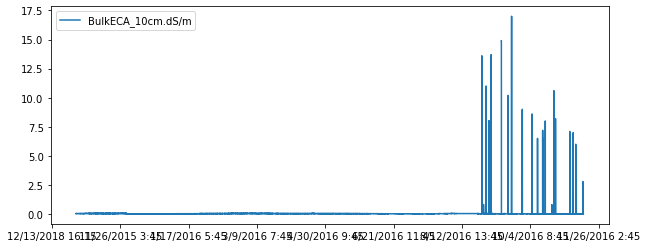

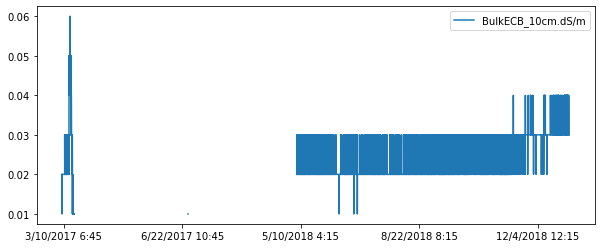

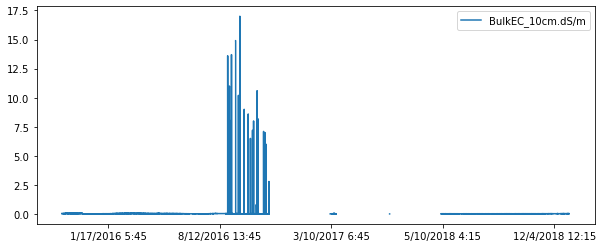

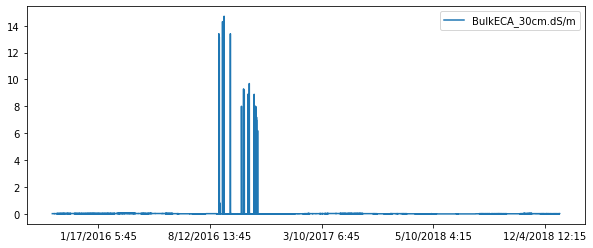

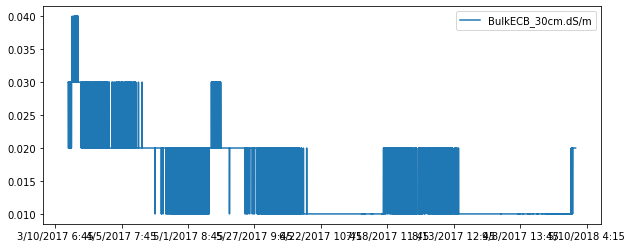

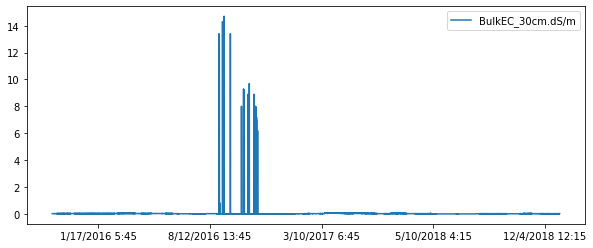

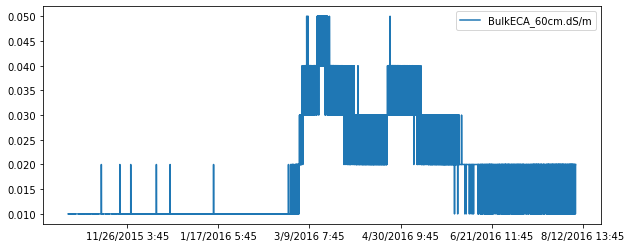

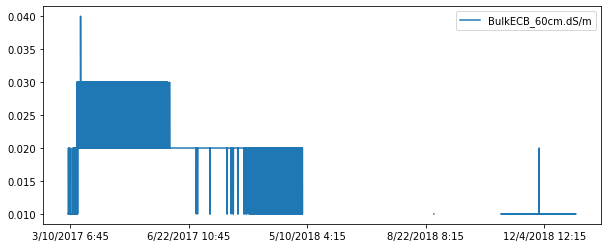

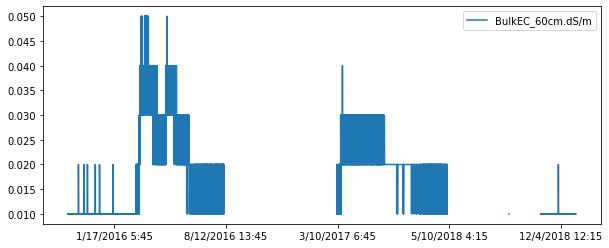

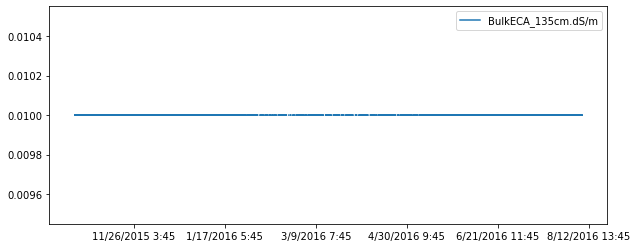

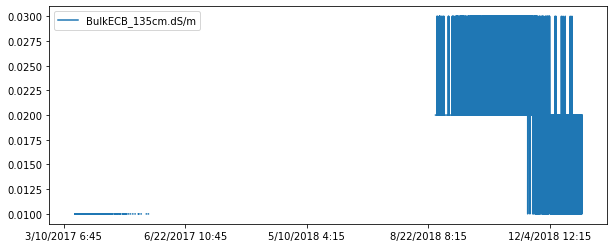

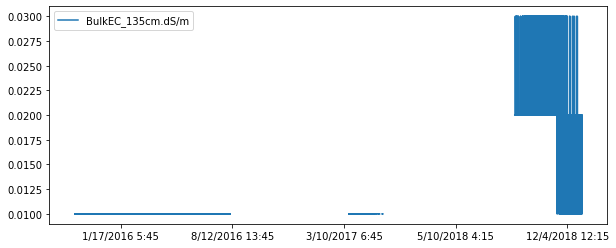

In [12]:
#Plot Bulk EC

plt.show()
df.plot(use_index=True, y='BulkECA_10cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkECB_10cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkEC_10cm.dS/m', figsize=(10,4))

df.plot(use_index=True, y='BulkECA_30cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkECB_30cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkEC_30cm.dS/m', figsize=(10,4))

df.plot(use_index=True, y='BulkECA_60cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkECB_60cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkEC_60cm.dS/m', figsize=(10,4))

df.plot(use_index=True, y='BulkECA_135cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkECB_135cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkEC_135cm.dS/m', figsize=(10,4))


In [13]:

df=df.drop(columns='BulkECA_10cm.dS/m')
df=df.drop(columns='BulkECB_10cm.dS/m')
df=df.drop(columns='BulkECA_30cm.dS/m')
df=df.drop(columns='BulkECB_30cm.dS/m')
df=df.drop(columns='BulkECA_60cm.dS/m')
df=df.drop(columns='BulkECB_60cm.dS/m')
df=df.drop(columns='BulkECA_135cm.dS/m')
df=df.drop(columns='BulkECB_135cm.dS/m')



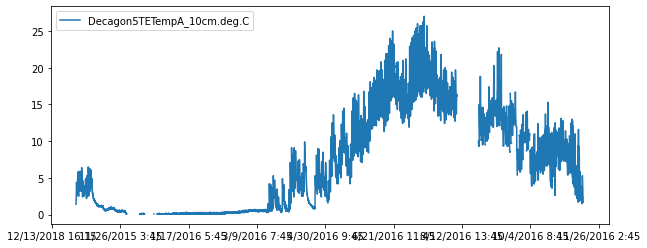

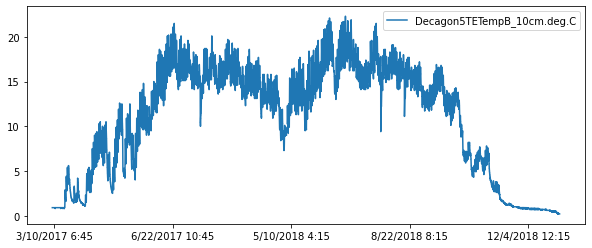

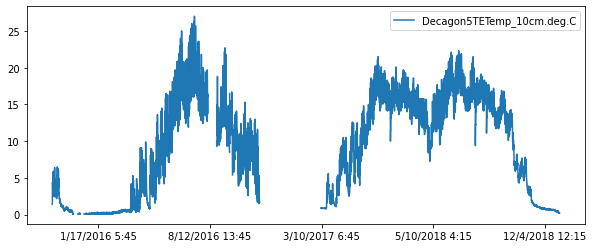

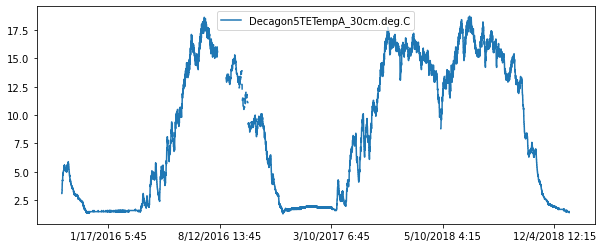

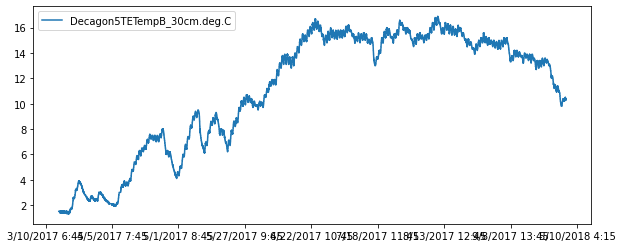

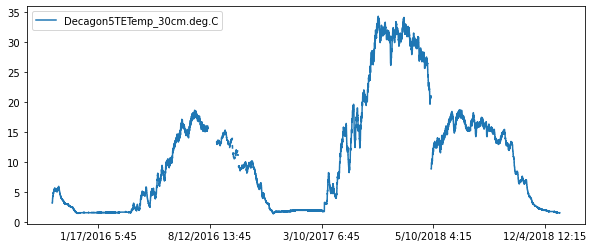

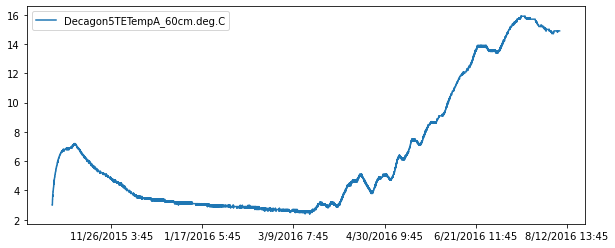

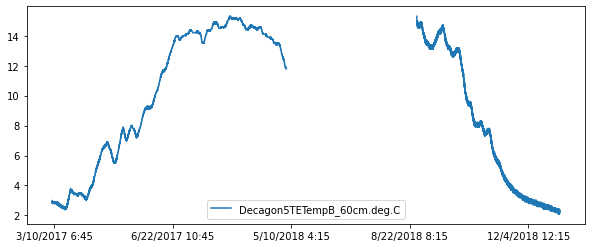

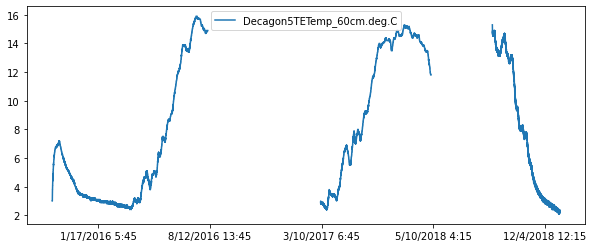

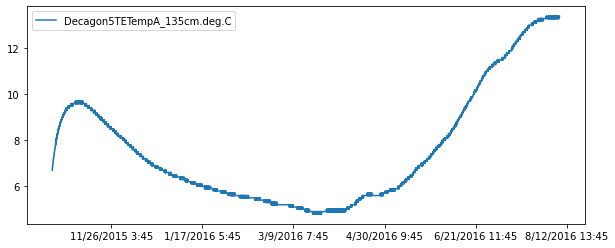

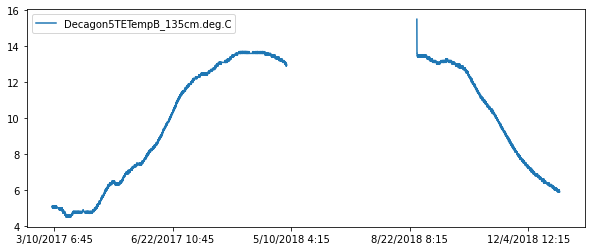

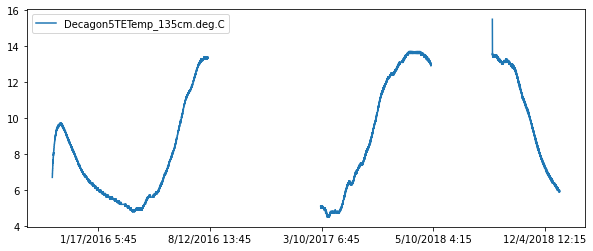

In [14]:
#Plot Decagon5TE Temps

plt.show()
df.plot(use_index=True, y='Decagon5TETempA_10cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETempB_10cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETemp_10cm.deg.C', figsize=(10,4))


df.plot(use_index=True, y='Decagon5TETempA_30cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETempB_30cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETemp_30cm.deg.C', figsize=(10,4))


df.plot(use_index=True, y='Decagon5TETempA_60cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETempB_60cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETemp_60cm.deg.C', figsize=(10,4))


df.plot(use_index=True, y='Decagon5TETempA_135cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETempB_135cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETemp_135cm.deg.C', figsize=(10,4))




In [15]:
df=df.drop(columns='Decagon5TETemp_10cm.deg.C')
df=df.drop(columns='Decagon5TETemp_30cm.deg.C')
df=df.drop(columns='Decagon5TETemp_60cm.deg.C')
df=df.drop(columns='Decagon5TETemp_135cm.deg.C')
df=df.drop(columns='Decagon5TETempA_10cm.deg.C')
df=df.drop(columns='Decagon5TETempA_30cm.deg.C')
df=df.drop(columns='Decagon5TETempA_60cm.deg.C')
df=df.drop(columns='Decagon5TETempA_135cm.deg.C')
df=df.drop(columns='Decagon5TETempB_10cm.deg.C')
df=df.drop(columns='Decagon5TETempB_30cm.deg.C')
df=df.drop(columns='Decagon5TETempB_60cm.deg.C')
df=df.drop(columns='Decagon5TETempB_135cm.deg.C')




In [16]:
output=df.copy()
today = dt.date.today()
outfile = '../../processed_data/Catalina-Jemez/Green_Pit1_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [17]:
output

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,...,SoilMoistureA_30cm.m3m3,SoilMoistureB_30cm.m3m3,PRISM_precip.mm,SoilMoisture_10cm.m3m3,SoilMoisture_60cm.m3m3,SoilMoisture_135cm.m3m3,BulkEC_10cm.dS/m,BulkEC_30cm.dS/m,BulkEC_60cm.dS/m,BulkEC_135cm.dS/m
10/23/2015 9:30,3.594,7.473,8.689,11.175,19.754,19.506,20.781,20.494,760.036,872.332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 9:45,3.750,7.621,8.875,11.416,20.063,19.929,21.231,20.948,765.288,896.402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 10:00,3.878,7.605,8.870,11.412,19.967,19.935,21.229,20.948,771.416,906.071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 10:15,4.100,7.631,8.887,11.445,19.964,19.955,21.213,20.954,773.689,917.356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 10:30,4.511,7.689,8.938,11.502,19.984,19.959,21.205,20.980,776.056,935.109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
